In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import lingam
from lingam import DirectLiNGAM
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score
from causallearn.utils.GraphUtils import GraphUtils
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro









df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename", "start_time", "end_time", "edge", "meterID"])
df_clean.fillna(df_clean.median(), inplace=True)

X_numeric = df_clean.select_dtypes(include=['float64', 'int64'])



No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

In [3]:
high_vif_features = vif_data[vif_data["VIF"] > 50]["Feature"].tolist()
X_filtered = X_numeric.drop(columns=high_vif_features)

In [4]:
target = "average_power_consumption"
X = df_clean.drop(columns=[target])
y = df_clean[target]
# feature_names = df_clean.columns.tolist()


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1))  
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()




In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [7]:
# X_lingam_numeric = X_lingam.select_dtypes(include=['float64', 'int64'])

model = DirectLiNGAM()
model.fit(X_filtered)
adj_matrix = model.adjacency_matrix_
feature_names = X_filtered.columns.tolist()
target = "average_power_consumption"
target_index = feature_names.index(target)

In [8]:
# adjacency_matrix = model.adjacency_matrix_

# print("Causal Structure (Adjacency Matrix):")
# print(adjacency_matrix)

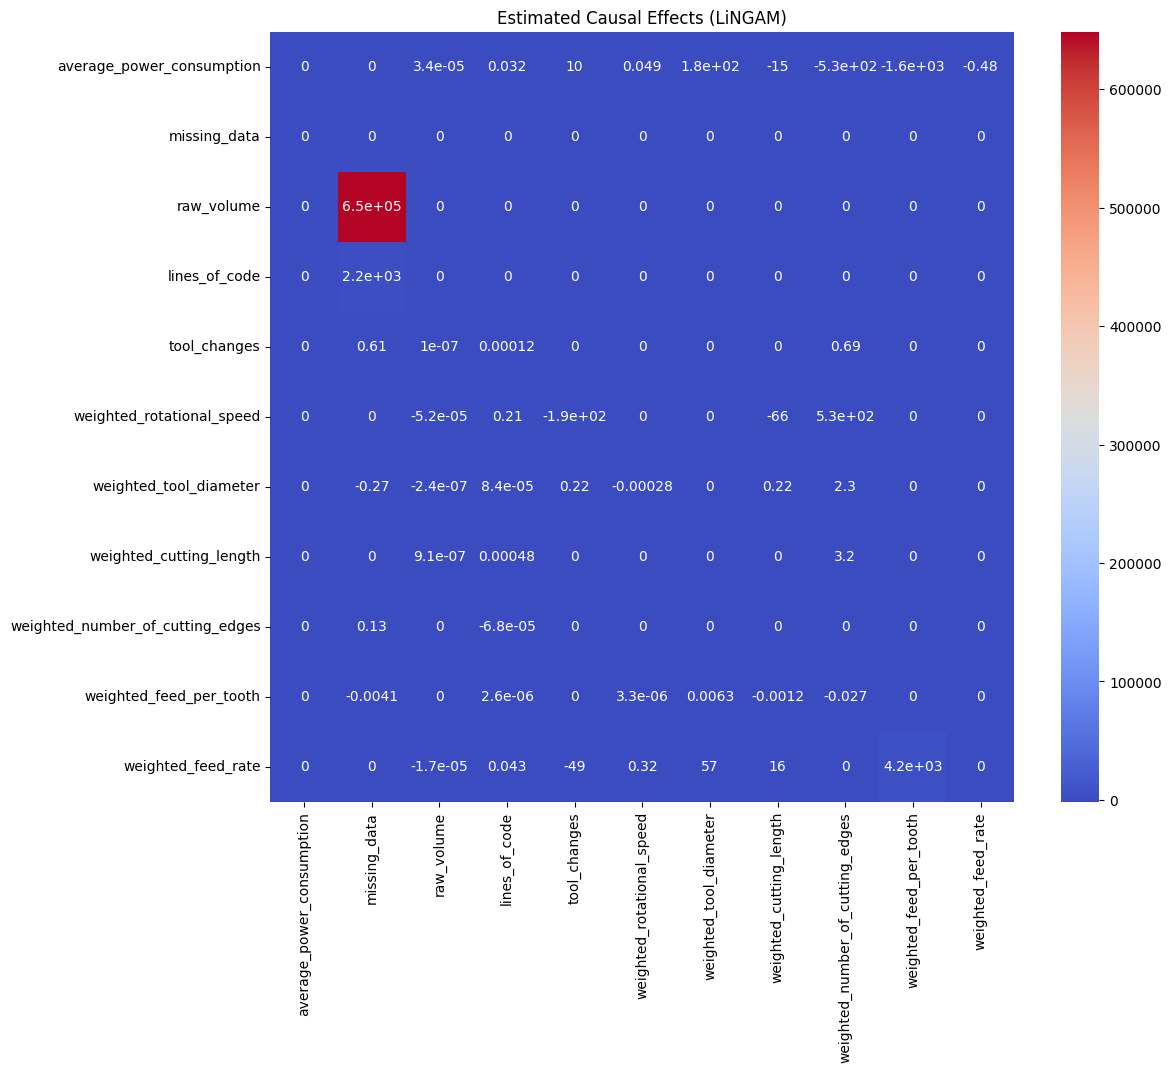

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(adj_matrix, xticklabels=feature_names, yticklabels=feature_names, annot=True, cmap="coolwarm")
plt.title("Estimated Causal Effects (LiNGAM)")
plt.show()

In [10]:
def adjacency_to_edge_list(adj_matrix, feature_names, threshold=0.05):
    edges = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if abs(adj_matrix[i, j]) > threshold and i != j:
                edges.append((feature_names[i], feature_names[j]))
    return edges

lingam_edges = adjacency_to_edge_list(adj_matrix, feature_names)

print("\nFeatures causing 'average_power_consumption':")


Features causing 'average_power_consumption':


In [11]:
target = "average_power_consumption"
if target in feature_names:
    target_index = feature_names.index(target)
    for i, val in enumerate(adj_matrix[:, target_index]):
        if abs(val) > 0.05:
            print(f"{feature_names[i]} → {target} (effect: {val:.2f})")
else:
    print("Target variable was removed due to high VIF!")

In [12]:
# X_with_target = df.select_dtypes(include=['float64', 'int64'])
# model.fit(X_with_target)
# adj_matrix = model.adjacency_matrix_
# feature_names = df.columns.tolist()
# target_index = X_with_target.columns.get_loc('average_power_consumption')
# causal_sources = adj_matrix[:, target_index]  
# print("Features that cause average power consumption:")
# for i, val in enumerate(causal_sources):
#     if abs(val) > 0.05:  
#         print(f"{X_with_target.columns[i]} → average_power_consumption (effect: {val:.2f})")


In [13]:
ground_truth_edges = [
    ("weighted_cutting_speed", "average_power_consumption"),
    ("weighted_rotational_speed", "average_power_consumption"),
    ("processing_time", "average_power_consumption")
]

In [15]:
def compute_metrics(true_edges, pred_edges):
    true_set = set(true_edges)
    pred_set = set(pred_edges)

    all_nodes = sorted(set([n for edge in true_set | pred_set for n in edge]))

    true_graph = nx.DiGraph()
    pred_graph = nx.DiGraph()
    true_graph.add_nodes_from(all_nodes)
    pred_graph.add_nodes_from(all_nodes)
    true_graph.add_edges_from(true_set)
    pred_graph.add_edges_from(pred_set)

    node_to_idx = {node: i for i, node in enumerate(all_nodes)}
    n = len(all_nodes)
    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))

    for src, tgt in true_set:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    for src, tgt in pred_set:
        pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1

    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()

    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    shd_val = SHD(true_graph, pred_graph)

    return precision, recall, f1, shd_val


In [16]:
for col in X_numeric.columns:
    stat, p = shapiro(X_numeric[col])
    print(f"{col}: p-value = {p:.4f}")

    if p < 0.05:
        print(f"❌ {col} is likely NOT Gaussian (reject null hypothesis)")
    else:
        print(f"✅ {col} may be Gaussian (fail to reject null hypothesis)")


processing_time: p-value = 0.0000
❌ processing_time is likely NOT Gaussian (reject null hypothesis)
average_power_consumption: p-value = 0.0000
❌ average_power_consumption is likely NOT Gaussian (reject null hypothesis)
missing_data: p-value = 0.0000
❌ missing_data is likely NOT Gaussian (reject null hypothesis)
raw_volume: p-value = 0.0000
❌ raw_volume is likely NOT Gaussian (reject null hypothesis)
lines_of_code: p-value = 0.0000
❌ lines_of_code is likely NOT Gaussian (reject null hypothesis)
tool_changes: p-value = 0.0000
❌ tool_changes is likely NOT Gaussian (reject null hypothesis)
travels_to_zero_point_in_rapid_traverse: p-value = 0.0000
❌ travels_to_zero_point_in_rapid_traverse is likely NOT Gaussian (reject null hypothesis)
axes_rotation: p-value = 0.0000
❌ axes_rotation is likely NOT Gaussian (reject null hypothesis)
weighted_rotational_speed: p-value = 0.0000
❌ weighted_rotational_speed is likely NOT Gaussian (reject null hypothesis)
weighted_tool_diameter: p-value = 0.0000
❌

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif_data)


                                    Feature           VIF
0                           processing_time  5.780786e+01
1                 average_power_consumption  6.693022e+00
2                              missing_data  5.290047e+00
3                                raw_volume  3.317569e+00
4                             lines_of_code  1.290216e+01
5                              tool_changes  7.654953e+00
6   travels_to_zero_point_in_rapid_traverse  2.685061e+06
7                             axes_rotation  2.711721e+06
8                 weighted_rotational_speed  2.234667e+01
9                    weighted_tool_diameter  1.701372e+01
10                  weighted_cutting_length  1.510860e+01
11         weighted_number_of_cutting_edges  9.763721e+00
12                   weighted_cutting_speed  5.128245e+01
13                  weighted_feed_per_tooth  2.757935e+00
14                       weighted_feed_rate  2.973406e+01


In [18]:
lingam_edges = adjacency_to_edge_list(adj_matrix, feature_names)

lingam_precision, lingam_recall, lingam_f1, lingam_shd = compute_metrics(ground_truth_edges, lingam_edges)


In [19]:
print("\n--- LiNGAM Causal Metrics ---")
print(f"Precision: {lingam_precision:.3f}")
print(f"Recall:    {lingam_recall:.3f}")
print(f"F1 Score:  {lingam_f1:.3f}")
print(f"SHD:       {lingam_shd}")


--- LiNGAM Causal Metrics ---
Precision: 0.000
Recall:    0.000
F1 Score:  0.000
SHD:       28


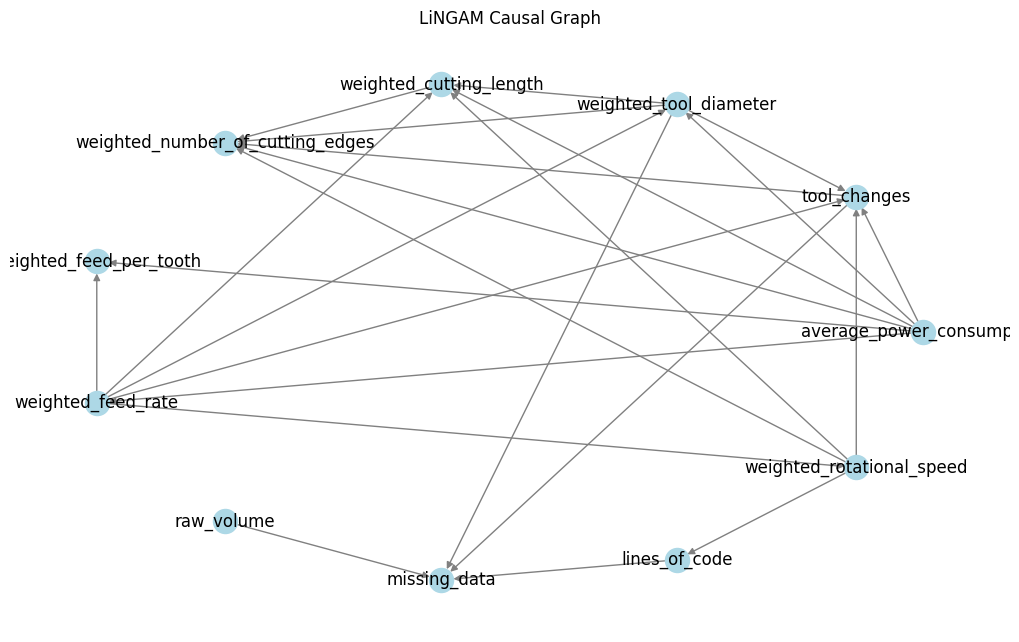

In [29]:
strong_threshold = 0.20
G = nx.DiGraph()

for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if abs(adj_matrix[i, j]) > strong_threshold and i != j:
            G.add_edge(feature_names[i], feature_names[j])  

plt.figure(figsize=(10, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)

plt.title("LiNGAM Causal Graph")
plt.show()


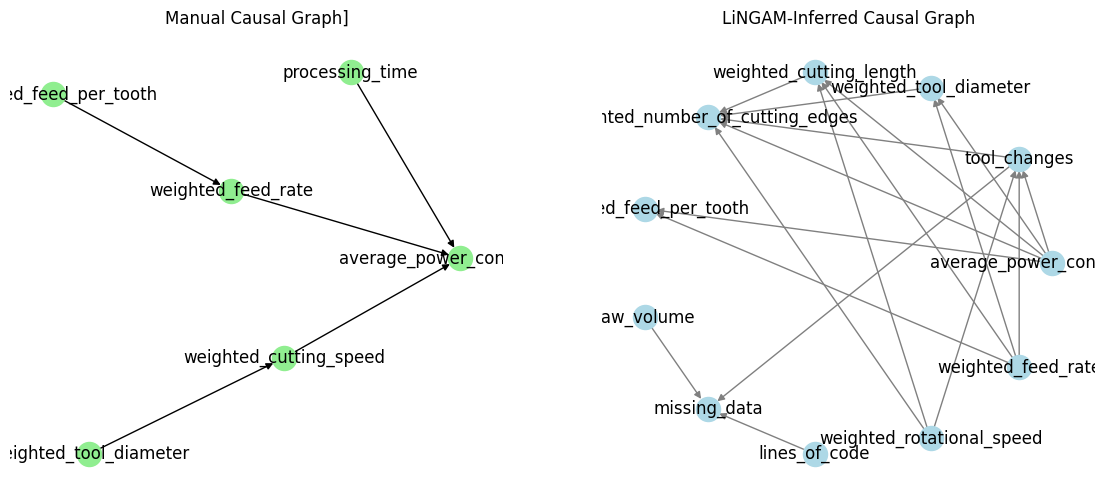

In [34]:
ground_truth_edges = [
    ("processing_time", "average_power_consumption"),
    ("weighted_cutting_speed", "average_power_consumption"),
    ("weighted_feed_rate", "average_power_consumption"),
    ("weighted_tool_diameter", "weighted_cutting_speed"),
    ("weighted_feed_per_tooth", "weighted_feed_rate"),
]

G_true = nx.DiGraph()
G_true.add_edges_from(ground_truth_edges)

G_lingam = nx.DiGraph()
strong_threshold = 0.60 
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if abs(adj_matrix[i, j]) > strong_threshold and i != j:
            G_lingam.add_edge(feature_names[i], feature_names[j])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pos_true = nx.spring_layout(G_true, seed = 42)
nx.draw(G_true, pos_true, with_labels=True, node_color="lightgreen", edge_color="black", arrows=True, ax=axes[0])
axes[0].set_title("Manual Causal Graph]")

pos_lingam = nx.circular_layout(G_lingam)
nx.draw(G_lingam, pos_lingam, with_labels=True, node_color="lightblue", edge_color="gray", arrows=True, ax=axes[1])
axes[1].set_title("LiNGAM-Inferred Causal Graph")

plt.show()
